# Getting started

This notebook shows how to get started with Quantus on tensorflow

In [117]:
# Imports general.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.auto import tqdm
import gc

import quantus
from quantus.metrics import *

%load_ext autoreload
%autoreload 2

tf.config.list_physical_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Re-run this cell if python hogs too much memory
gc.collect()

## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [90]:
# Load dataset

IMG_SIZE = 224


ds = tfds.load(
    'imagenet_v2',
    split=['test'],
    as_supervised=True,
    try_gcs=True,
    batch_size=32,
)

x_batch, y_batch = ds[0].skip(8).take(1).as_numpy_iterator().next()
x_batch = tf.image.resize(x_batch, (IMG_SIZE, IMG_SIZE)).numpy()
x_batch.shape

(32, 224, 224, 3)

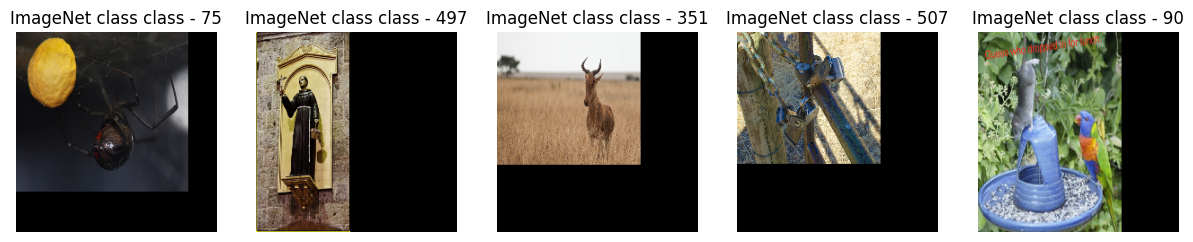

In [91]:
# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i, (x, y) in enumerate(zip(x_batch[:nr_images], y_batch[:nr_images])):
    axes[i].imshow(x.astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class class - {y}")
    axes[i].axis("off")

plt.show()

### 1.2 Load a pre-trained model

In [92]:
model = tf.keras.applications.EfficientNetB0()
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 224, 224, 3) then the attributions should be of size (128, 224, 224, 1).

In [93]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch_intgrad = quantus.explain(model, x_batch, y_batch, method='IntegratedGradients')
a_batch_intgrad.shape

2022-09-09 19:33:37.760611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-09 19:33:42.484167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(32, 224, 224)

Visualise attributions given model and pairs of input-output.

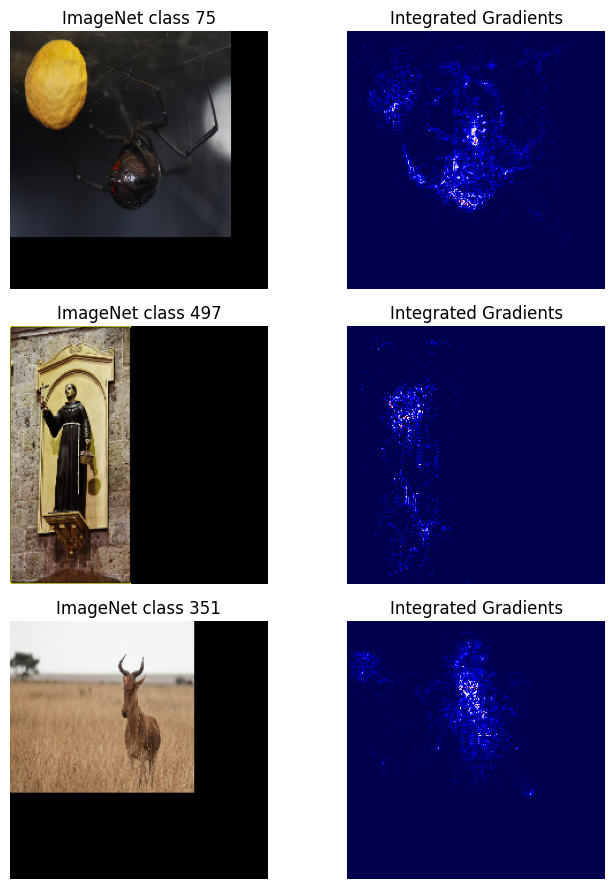

In [96]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*2.5, int(nr_images*3)))
for i, (x, y, a) in enumerate(zip(x_batch[:nr_images], y_batch[:nr_images], a_batch_intgrad[:nr_images])):
    axes[i, 0].imshow(x.astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i, 0].title.set_text(f"ImageNet class {y}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(a, cmap="seismic")
    axes[i, 1].title.set_text(f"Integrated Gradients")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

## 2. Quantative evaluation using Quantus
In this part, few of the metrics available in quantus are demonstrated

In [105]:
# Define params for evaluation.
params_eval_maxs = {
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_noise,
    "similarity_func": quantus.difference,
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "display_progressbar": True,
    "return_aggregate": True,
}

## [MaxSensitivity](https://arxiv.org/pdf/2005.00631.pdf)
This metric tests how the explanations maximally change while subject to slight perturbations.

In [108]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
ms = quantus.MaxSensitivity(**params_eval_maxs)

scores_intgrad_maxs = ms(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_intgrad,
   explain_func=quantus.explain,
   method="IntegratedGradients"
)
scores_intgrad_maxs

Evaluation of MaxSensitivity:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/normalise_func.py:15: RuntimeWarning: invalid value encountered in divide
  return a / a.max()


[3.0024383427349308e-05]

## [AvgSensitivity](https://arxiv.org/pdf/2005.00631.pdf)
This metric tests how the explanations change in average while subject to slight perturbations.

In [136]:
avg_sen = quantus.AvgSensitivity(**params_eval_maxs)

result_avg_sen = avg_sen(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_intgrad,
   explain_func=quantus.explain,
   method="IntegratedGradients"
)
result_avg_sen

Evaluation of AvgSensitivity:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/normalise_func.py:15: RuntimeWarning: invalid value encountered in divide
  return a / a.max()


[nan]

Well, this result was not intended. We will fix it soon. [GitHub issue](https://github.com/understandable-machine-intelligence-lab/Quantus/issues/145).
For now, it is out of the scope, so we will have to bear with it for some time.

## [Selectivity](https://arxiv.org/pdf/1706.07979.pdf)

In [ ]:
# Calculate Selectivity (Ancona et al., 2019)
params_eval_slct = {
    "perturb_func": quantus.random_noise,
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "perturb_baseline": "random",
    "patch_size": 4,
    "nr_channels": 3,
    "display_progressbar": True
}

selectivity = quantus.Selectivity(**params_eval_slct)

result_selectivity = selectivity(model=model,
                                 x_batch=x_batch,
                                 y_batch=y_batch,
                                 a_batch=a_batch_intgrad,
                                 explain_func=quantus.explain,
                                 method="IntegratedGradients"
                                 )

## [Relative Stability](https://arxiv.org/pdf/2203.06877.pdf)
RS leverages the changes in explanations, as a subject to change in
- input -> relative input stability
- output logits -> relative output stability
- internal representations -> relative representation stability

Let's pre-compute perturbations + explanations to speed it up

In [110]:
xs_batch = []


for _ in tqdm(range(50)):
    xs = quantus.random_noise(x_batch)
    logits = model.predict(xs, verbose=0)
    labels = np.argmax(logits, axis=1)

    same_label_indexes = np.argwhere(labels == y_batch)
    xs = xs[same_label_indexes].reshape(-1, *xs.shape[1:])
    xs_batch.append(xs)

# pull all new images into 0 axes
xs_batch = np.vstack(xs_batch)
# drop images, which cause dims not to be divisible
xs_batch = xs_batch[: xs_batch.shape[0] // x_batch.shape[0] * x_batch.shape[0]]
# make xs_batch have the same shape as x_batch, with new batching axis at 0
xs_batch = xs_batch.reshape(-1, *x_batch.shape)
xs_batch.shape

  0%|          | 0/50 [00:00<?, ?it/s]

(26, 32, 224, 224, 3)

In [111]:
as_batch = np.asarray([
    quantus.explain(model, i, y_batch, method='IntegratedGradients')
    for i in tqdm(xs_batch)
])

  0%|          | 0/26 [00:00<?, ?it/s]

In [114]:
rs_eval_params = {
    "display_progressbar": True,
    "normalise": True,
    "abs": True,
    "return_aggregate": True
}
ris = quantus.RelativeInputStability(**rs_eval_params)

ris_result = ris(
    model,
    x_batch=x_batch,
    xs_batch=xs_batch,
    a_batch=a_batch_intgrad,
    as_batch=as_batch,
    y_batch=y_batch
)
ris_result

0.048262970189340934

In [119]:
ros = quantus.RelativeOutputStability(**rs_eval_params)

ros_result = ros(
    model,
    x_batch=x_batch,
    xs_batch=xs_batch,
    a_batch=a_batch_intgrad,
    as_batch=as_batch,
    y_batch=y_batch
)
ros_result

1688.0110650486893

The authors of the RS paper didn't provide any code examples.
Neither did they specify which internal representations to take into account.
We expect RRS to be sensitive to this choice. So, let's try a few options out!

User can provide either `layer_names` or `layer_indices` as kwargs, to select, which layers outputs should be taken into account.
Providing neither will force usage of all. Warning, this could be really memory consuming for big models,
as it relies on keras Functional API to extract features from computational graph. (Which will rebuild the model for each selected output).

In [122]:
[i.name for i in model.layers]

['input_2',
 'rescaling_1',
 'normalization_1',
 'tf.math.truediv_1',
 'stem_conv_pad',
 'stem_conv',
 'stem_bn',
 'stem_activation',
 'block1a_dwconv',
 'block1a_bn',
 'block1a_activation',
 'block1a_se_squeeze',
 'block1a_se_reshape',
 'block1a_se_reduce',
 'block1a_se_expand',
 'block1a_se_excite',
 'block1a_project_conv',
 'block1a_project_bn',
 'block2a_expand_conv',
 'block2a_expand_bn',
 'block2a_expand_activation',
 'block2a_dwconv_pad',
 'block2a_dwconv',
 'block2a_bn',
 'block2a_activation',
 'block2a_se_squeeze',
 'block2a_se_reshape',
 'block2a_se_reduce',
 'block2a_se_expand',
 'block2a_se_excite',
 'block2a_project_conv',
 'block2a_project_bn',
 'block2b_expand_conv',
 'block2b_expand_bn',
 'block2b_expand_activation',
 'block2b_dwconv',
 'block2b_bn',
 'block2b_activation',
 'block2b_se_squeeze',
 'block2b_se_reshape',
 'block2b_se_reduce',
 'block2b_se_expand',
 'block2b_se_excite',
 'block2b_project_conv',
 'block2b_project_bn',
 'block2b_drop',
 'block2b_add',
 'block

In [123]:
rrs = quantus.RelativeRepresentationStability(**rs_eval_params)

rrs_result_1 = rrs(
    model,
    x_batch=x_batch,
    xs_batch=xs_batch,
    a_batch=a_batch_intgrad,
    as_batch=as_batch,
    y_batch=y_batch,
    layer_names=['top_conv']
)
rrs_result_1

0.6839803174158577

In [124]:
rrs_result_2 = rrs(
    model,
    x_batch=x_batch,
    xs_batch=xs_batch,
    a_batch=a_batch_intgrad,
    as_batch=as_batch,
    y_batch=y_batch,
    layer_indices=[3, 4, 5]
)
rrs_result_2

12.1695858146796

In [131]:
pd.DataFrame(
    [
        scores_intgrad_maxs[0],
        ris_result, ros_result,
        rrs_result_1,
        rrs_result_2
    ],
    index=[
        'MaxSensitivity',
        'RIS',
        'ROS',
        'RRS(top_conv)',
        'RRS[3, 4, 5]'
    ]
)

,0
MaxSensitivity,0.000030
RIS,0.048263
ROS,1688.011065
RRS(top_conv),0.683980
"RRS[3, 4, 5]",12.169586
